In [29]:
import tensorflow as tf
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPool2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from time import time
import itertools
import math
import visualkeras

# Loading data

In [4]:
data_dir = r'/jet/home/mhrahman/Projects/HW6/DS-1_36W_images'
vap_data = pd.read_csv(r'/jet/home/mhrahman/Projects/HW5/DS-1_36W_vapor_fraction.txt',sep = '\t')
vap_data = vap_data.rename(columns={'Time (ms)':'Time','Vapor Fraction':'Vapor Fraction'})
vap_data.index = np.arange(1,len(vap_data)+1)
img_file = glob.glob(os.path.join(data_dir,'*'))

In [43]:
vap_data.iloc[0]['Vapor Fraction']

0.566643555

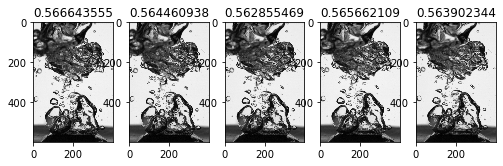

In [45]:
plt.figure(figsize=(10,10))
for i in range(6):
    if i >= 5:
        break
    img_ = Image.open(img_file[i]).resize((400,600))
    plt.subplot(1,6,i+1)
    plt.title(vap_data.iloc[i]['Vapor Fraction'])
    plt.imshow(img_,cmap='gray',interpolation='none')
plt.savefig(r'/jet/home/mhrahman/Projects/HW6/Figures/Images.jpg',dpi = 300)
plt.show()

# Prepare training, validation and testing dataset

In [32]:
img_file = sorted(img_file)

In [33]:
X = []
Y = []
for i in img_file:
    img = np.array(Image.open(i).resize((80,128)).convert('L'))/255
    ind = int(i.split("/")[-1].split(".")[1])
    vapor_f = vap_data.loc[ind]['Vapor Fraction']
    X.append(img)
    Y.append(vapor_f)

In [34]:
X = np.array(X)
Y = np.array(Y)

In [35]:
X = np.reshape(X,(X.shape[0],X.shape[1],X.shape[2],1))

In [36]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.2,shuffle = False)

# CNN regression model

In [37]:
model_cnn = Sequential([
    Conv2D(filters= 32,kernel_size=(3,3),padding='same',input_shape = (128,80,1)),
    MaxPool2D(pool_size= (2,2)),
    Conv2D(filters=64,kernel_size=(3,3),padding='same'),
    MaxPool2D(pool_size= (2,2)),
    Conv2D(filters=128,kernel_size=(3,3),padding='same'),
    MaxPool2D(pool_size= (2,2)),
    Flatten(),
    Dense(units=100,activation='sigmoid'),
    Dense(units=1,activation='linear')
])

In [38]:
model = model_cnn

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
model.summary()
with open('modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 80, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0

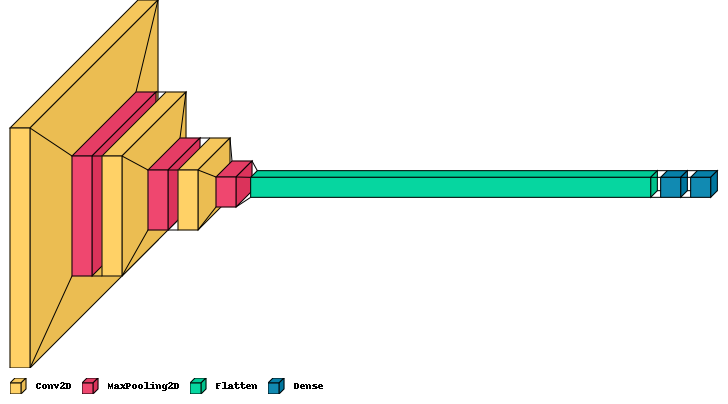

In [40]:
visualkeras.layered_view(model,legend = True,scale_xy=3,to_file='output.png')

In [ ]:
class TimeCallback(Callback):
    def on_train_begin(self,logs={}):
        self.logs=[]
    def on_epoch_begin(self,epoch,logs={}):
        self.starttime = time()
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(time()-self.starttime)
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience = 20,min_delta = 1)
cb = TimeCallback()
checkpoints = ModelCheckpoint('weight_03.hdf5',monitor='val_loss',verbose=1,save_best_only= True,mode='min')

In [166]:
model_history = model.fit(x_train,y_train,validation_split = 0.2,batch_size = 32,epochs = 100,
         callbacks = [es,cb,checkpoints])

Train on 3199 samples, validate on 800 samples
Epoch 1/2
3199/3199 [==============================] - 105s 33ms/sample - loss: 0.1935 - val_loss: 0.0049
Epoch 2/2
3199/3199 [==============================] - 104s 32ms/sample - loss: 4.8032e-04 - val_loss: 0.0027


# Plots

In [ ]:
#plot training and validation curve
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(["Training loss","Validation loss"])
plt.savefig('/jet/home/mhrahman/Projects/HW6/Figures/Classification_loss.jpg',dpi = 300)
plt.show()

In [ ]:
plt.plot(cb.logs)
plt.title('Time per epoch')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.legend(['Time'],loc = 'upper right')
#path = r'/jet/home/mhrahman/Projects/HW1/Figures/Classification_loss.jpg'
plt.savefig(r'/jet/home/mhrahman/Projects/HW6/Figures/Time.jpg', dpi = 300)
plt.show()

In [167]:
y_predict = model.predict(x_test)
error = math.sqrt(mean_squared_error(y_true=y_test,y_pred=y_predict))
print(error)

0.0027902545773337913


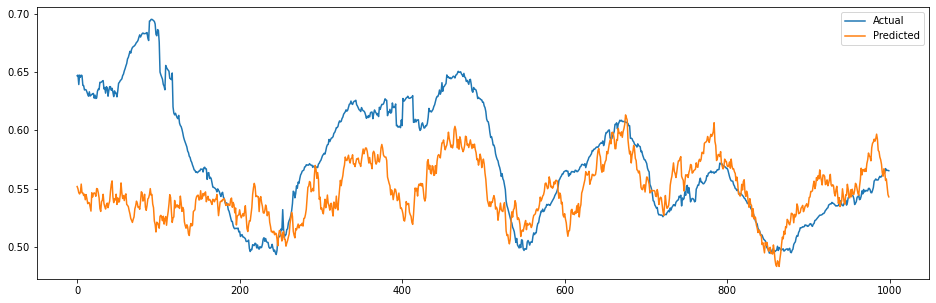

In [168]:
plt.figure(figsize=(16,5))
plt.plot(y_test,label = "Actual")
plt.plot(y_predict,label = "Predicted")
plt.legend()
plt.savefig(r'/jet/home/mhrahman/Projects/HW6/Figures/Prediction.jpg',dpi = 300)
plt.show()